In [1]:
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import math

In [2]:
base_path = "./runaway-seg-10"
destination = "./cropped_roboflow"
crop_size = 200
train = 0.7
val = 0.15
test = 0.15

In [3]:
image_paths = []
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".jpg"):
            image_paths.append(os.path.join(root, file))

In [4]:
mask_paths = []
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".txt"):
            mask_paths.append(os.path.join(root, file))

In [5]:
crops = []
for image_path in image_paths:
    image = Image.open(image_path)
    width, height = image.size
    mask_path = os.path.join(base_path, image_path.split("/")[2], "labels", os.path.basename(image_path).replace(".jpg", ".txt"))
    with open(mask_path, "r") as f:
        line = f.readlines()[0]
        coordinates = line.split(" ")[1:]
        relative_x = [float(x) * width for x in coordinates[::2]]
        relative_y = [float(y) * height for y in coordinates[1::2]]

        x_min = min(relative_x)
        x_max = max(relative_x)
        y_min = min(relative_y)
        y_max = max(relative_y)

        x_min_valid = max(0, x_max - crop_size)
        x_max_valid = min(width - crop_size, x_min)
        y_min_valid = max(0, y_max - crop_size)
        y_max_valid = min(height - crop_size, y_min)

        if x_min_valid >= x_max_valid or y_min_valid >= y_max_valid:
            print("Invalid crop for image " + image_path)
            continue

        crop_x = random.randint(math.ceil(x_min_valid), math.floor(x_max_valid))
        crop_y = random.randint(math.ceil(y_min_valid), math.floor(y_max_valid))

        crop = image.crop((crop_x, crop_y, crop_x + crop_size, crop_y + crop_size))
        
        relative_x = [(x - crop_x) for x in relative_x]
        relative_y = [(y - crop_y) for y in relative_y]
        
        crops.append((crop, "0 " + " ".join([str(x / crop_size) for x in relative_x]) + " " + " ".join([str(y / crop_size) for y in relative_y])))
        # plt.imshow(crop)

        # for x, y in zip(relative_x, relative_y):
        #     plt.scatter(x, y, c="red")
        # plt.show()
        # crops.append((crop, "0 " + " ".join([str(x / crop_size) for x in relative_x]) + " " + " ".join([str(y / crop_size) for y in relative_y])))

Invalid crop for image ./runaway-seg-10/train/images/104_2022-11-12_2022-12-22_png_jpg.rf.250d12cd0dcb07f0e1a4bca259b1a0ae.jpg
Invalid crop for image ./runaway-seg-10/train/images/104_2022-02-07_2022-03-19_png_jpg.rf.9116ccc8909dc4e7109b0367971660eb.jpg
Invalid crop for image ./runaway-seg-10/train/images/104_2022-11-12_2022-12-22_png_jpg.rf.4a5ea569578153ec12b0c488354875e8.jpg
Invalid crop for image ./runaway-seg-10/train/images/104_2021-10-10_2021-11-19_png_jpg.rf.0e9a8ff6274a36d72df2a6e76d6240e9.jpg
Invalid crop for image ./runaway-seg-10/train/images/104_2022-02-07_2022-03-19_png_jpg.rf.6a0ac0612a0788b5dc50036f36b3aba4.jpg
Invalid crop for image ./runaway-seg-10/train/images/104_2022-11-12_2022-12-22_png_jpg.rf.266d5a9856ce32ddde9398a47b63c46a.jpg
Invalid crop for image ./runaway-seg-10/train/images/104_2022-07-16_2022-08-25_png_jpg.rf.4d80e61d783d99dd324c1c0debb2b7d1.jpg
Invalid crop for image ./runaway-seg-10/train/images/104_2022-02-07_2022-03-19_png_jpg.rf.1c6c50d1780acb07a5158

In [6]:
train_size = int(len(crops) * train)
val_size = int(len(crops) * val)
test_size = int(len(crops) * test)

In [7]:
train_crops = random.sample(crops, train_size)
val_crops = random.sample([x for x in crops if x not in train_crops], val_size)
test_crops = [x for x in crops if x not in train_crops and x not in val_crops]

In [8]:
print(len(image_paths))
print(len(crops))
print(len(train_crops))
print(len(val_crops))
print(len(test_crops))

1175
1160
812
174
174


In [9]:
folder = "train"
os.makedirs(os.path.join(destination, folder, "images"), exist_ok=True)
os.makedirs(os.path.join(destination, folder, "labels"), exist_ok=True)
for image, data in train_crops:
    name = str(random.randint(0, 1000000))
    image.save(os.path.join(destination, folder, "images", name + ".jpg"))
    with open(os.path.join(destination, folder, "labels", name + ".txt"), "w") as f:
        f.write(data)

In [10]:
folder = "test"
os.makedirs(os.path.join(destination, folder, "images"), exist_ok=True)
os.makedirs(os.path.join(destination, folder, "labels"), exist_ok=True)
for image, data in test_crops:
    name = str(random.randint(0, 1000000))
    image.save(os.path.join(destination, folder, "images", name + ".jpg"))
    with open(os.path.join(destination, folder, "labels", name + ".txt"), "w") as f:
        f.write(data)

In [11]:
folder = "valid"
os.makedirs(os.path.join(destination, folder, "images"), exist_ok=True)
os.makedirs(os.path.join(destination, folder, "labels"), exist_ok=True)
for image, data in val_crops:
    name = str(random.randint(0, 1000000))
    image.save(os.path.join(destination, folder, "images", name + ".jpg"))
    with open(os.path.join(destination, folder, "labels", name + ".txt"), "w") as f:
        f.write(data)

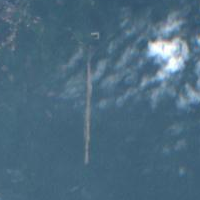

In [12]:
from IPython.display import Image, display

display(train_crops[0][0])